In [15]:
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from pathlib import Path
import pandas as pd
import numpy as np
import random
import datetime
import tensorflow.keras as keras
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support
import shutil

def initialise_session():
    K.clear_session()
    physical_devices = tf.config.list_physical_devices('GPU')
    num_physical_devices = len(physical_devices)
    print("GPUs Available: ", num_physical_devices)
    if num_physical_devices > 0:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
def find_directory():
    try:
        # Check if running in a Jupyter notebook
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            # Running in a Jupyter notebook
            directory = os.getcwd()
        else:
            # Running in a standalone Python script
            directory = Path(__file__).parent
    except NameError:
        # Running in a standalone Python script
        directory = Path(__file__).parent
    return directory

def add_new_data(path_to_data):
    training_norm_path = f"{path_to_data}/training_norm.csv"
    training_norm = pd.read_csv(training_norm_path)

    path_to_new_images = f"{path_to_data}/training_data/new_data"
    filenames = os.listdir(path_to_new_images)
    if any('.png' in filename for filename in filenames):
        max_image_id = training_norm['image_id'].max()
        new_data = []
        for i, original_filename in enumerate(filenames):
            image_path = f"{path_to_new_images}/{original_filename}"
            try:
                Image.open(image_path)
            except UnidentifiedImageError:
                os.remove(image_path)
                continue
            filename = original_filename.split('.')[0]
            image_id = max_image_id + i + 1
            angle = (int(filename.split('_')[1]) - 50) / 80
            speed = int(filename.split('_')[2]) / 35
            if speed != 0 and speed != 1:
                os.remove(image_path)
                continue
            new_data.append({'image_id': image_id, 'angle': angle, 'speed': speed})
            new_image_path = f"{path_to_new_images}/{image_id}.png"
            os.rename(image_path, new_image_path)
            shutil.move(new_image_path, f"{path_to_data}/training_data/combined")
            
        new_data = pd.DataFrame(new_data)
        training_norm = pd.concat([training_norm, new_data], ignore_index=True)
        training_norm.to_csv(training_norm_path, index=False)
    return training_norm
            
def build_train_image_paths(path_to_data):
    training_norm = add_new_data(path_to_data)
    training_norm["speed"] = training_norm["speed"].astype(int)
    training_norm["image_id"] = training_norm["image_id"].apply(lambda x: f"{path_to_data}/training_data/combined/{x}.png")
    training_norm.rename(columns={"image_id": "image_path"}, inplace=True)
    
    train_image_paths_0 = training_norm[training_norm['speed'] == 0].reset_index(drop=True)
    train_image_paths_1 = training_norm[training_norm['speed'] == 1].reset_index(drop=True)
    return train_image_paths_0, train_image_paths_1

def build_test_image_paths(path_to_data):
    image_ids = np.arange(1, 1021)
    test_image_paths = pd.DataFrame({'image_path': []})
    for image_id in image_ids:
        full_path = str(f"{path_to_data}/test_data/test_data/{str(image_id)}.png")
        test_image_paths.loc[len(test_image_paths)] = full_path
    return test_image_paths
        
def build_image_paths(directory):
    path_to_data = f"{directory}/machine-learning-in-science-ii-2023"
    train_image_paths_0, train_image_paths_1 = build_train_image_paths(path_to_data)
    test_image_paths = build_test_image_paths(path_to_data)
    return train_image_paths_0, train_image_paths_1, test_image_paths
    
def load_training_images_and_labels(image_path, labels, weights, image_shape):
    # Define a function that maps each row to an image and a pair of labels
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_shape)
    speed_label = labels[0]
    angle_label = labels[1]
    speed_label = tf.cast(speed_label, tf.int32)
    angle_label = tf.cast(angle_label, tf.float32)
    return image, (speed_label, angle_label), weights

def augment(train_set, seed):
    image, labels, weights = train_set
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    return image, labels, weights

def build_training_validation_and_evaluation_sets(train_image_paths_0, train_image_paths_1, image_shape, batch_size, eval_split, train_val_split, speed_weights):
    speed_0_weights = np.ones(train_image_paths_0.shape[0]) * speed_weights[0]
    speed_1_weights = np.ones(train_image_paths_1.shape[0]) * speed_weights[1]
    dataset_0 = tf.data.Dataset.from_tensor_slices((train_image_paths_0['image_path'], 
                                                  (train_image_paths_0['speed'], train_image_paths_0['angle']),
                                                  (speed_0_weights, None)
                                                  ))
    dataset_1 = tf.data.Dataset.from_tensor_slices((train_image_paths_1['image_path'], 
                                                  (train_image_paths_1['speed'], train_image_paths_1['angle']),
                                                  (speed_1_weights, None)
                                                  ))
    
    dataset_0 = dataset_0.map(lambda x,y,z: load_training_images_and_labels(x,y,z, image_shape))
    dataset_1 = dataset_1.map(lambda x,y,z: load_training_images_and_labels(x,y,z, image_shape))
    
    dataset_0_size = dataset_0.cardinality().numpy()
    dataset_1_size = dataset_1.cardinality().numpy()
    num_images = dataset_0_size + dataset_1_size
    
    eval_0_size = int(dataset_0.cardinality().numpy()*eval_split)
    eval_1_size = int(dataset_1.cardinality().numpy()*eval_split)
    
    if eval_0_size <= eval_1_size:
        eval_half_size = eval_0_size
        less_zeros = True
        extra_ones = eval_1_size - eval_0_size
    else:
        eval_half_size = eval_1_size
        less_zeros = False
        
    dataset_0 = dataset_0.shuffle(buffer_size=dataset_0_size)
    dataset_1 = dataset_1.shuffle(buffer_size=dataset_1_size)
    dataset_0 = dataset_0.batch(eval_half_size)
    dataset_1 = dataset_1.batch(eval_half_size)
    
    eval_set_0s = dataset_0.take(1)
    eval_set_1s = dataset_1.take(1)
    
    eval_set_speed_size = eval_half_size*2
    eval_set_speed = eval_set_0s.concatenate(eval_set_1s).unbatch().shuffle(buffer_size=eval_set_speed_size).batch(batch_size)
    
    dataset_0 = dataset_0.skip(1).take(-1).unbatch()
    dataset_1 = dataset_1.skip(1).take(-1).unbatch()
    
    if less_zeros:
        dataset_1 = dataset_1.batch(extra_ones)
        eval_set_angle_size = eval_1_size
        eval_set_angle = dataset_1.take(1).concatenate(eval_set_1s).unbatch().shuffle(buffer_size=eval_set_angle_size).batch(batch_size)
        dataset_1 = dataset_1.skip(1).take(-1).unbatch()
    else:
        eval_set_angle_size = eval_half_size
        eval_set_angle = eval_set_1s.unbatch().shuffle(buffer_size=eval_set_angle_size).batch(batch_size)
    
    eval_set_speed_percentage = int(round((eval_set_speed_size / num_images) * 100, 0))
    eval_set_angle_percentage = int(round((eval_set_angle_size / num_images) * 100, 0))
    
    num_0s = dataset_0.reduce(0, lambda x,_: x+1).numpy()
    num_1s = dataset_1.reduce(0, lambda x,_: x+1).numpy()
    speed_split = f"{int(round((num_0s / (num_0s + num_1s))*100, 0))}/{int(round((num_1s / (num_0s + num_1s))*100, 0))}"
    dataset = dataset_0.concatenate(dataset_1)
    
    num_train_val_images = dataset.reduce(0, lambda x,_: x+1).numpy() 
    dataset = dataset.shuffle(buffer_size=num_train_val_images).batch(batch_size)
    num_batches = dataset.reduce(0, lambda x,_: x+1).numpy()

    train_batches = int(num_batches * train_val_split[0])
    val_batches = int(num_batches * train_val_split[1])

    train_set = dataset.take(train_batches)
    val_set = dataset.skip(train_batches)

    AUTOTUNE = tf.data.AUTOTUNE
    counter = tf.data.Dataset.counter()
    train_set = tf.data.Dataset.zip((train_set, (counter, counter)))
    train_set = train_set.map(augment, num_parallel_calls=AUTOTUNE)
    
    train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
    val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
    eval_set_speed = eval_set_speed.cache().prefetch(buffer_size=AUTOTUNE)
    eval_set_angle = eval_set_angle.cache().prefetch(buffer_size=AUTOTUNE)
    
    if (num_train_val_images % batch_size) != 0:
        num_full_batches = int(np.floor(num_train_val_images / batch_size))
        last_batch_size = num_train_val_images % num_full_batches
    else:
        last_batch_size = batch_size
        
    train_set_size = train_set.reduce(0, lambda x,_: x+1).numpy() * batch_size
    train_set_percentage = int(round((train_set_size / num_images) * 100, 0))
    
    val_set_size = (val_set.reduce(0, lambda x,_: x+1).numpy() - 1) * batch_size + last_batch_size
    val_set_percentage = int(round((val_set_size / num_images) * 100, 0))
    
    print(f"\nFound {num_images} images.")
    print(f"Using {train_set_size} ({train_set_percentage}%) for training (speed split {speed_split}).")
    print(f"Using {val_set_size} ({val_set_percentage}%) for validation.")
    print(f"Using {eval_set_speed_size} ({eval_set_speed_percentage}%) for evaluation of speed (speed split 50/50).")
    print(f"Using {eval_set_angle_size} ({eval_set_angle_percentage}%) for evaluation of angle.")
    
    return train_set, val_set, eval_set_speed, eval_set_angle

def build_model(image_shape):
    K.clear_session()
    inputs = keras.layers.Input(shape=image_shape+(3,))
    [speed_output, angle_output] = CNNs(image_shape)(inputs)

    # Name outputs
    speed_output = layers.Lambda(lambda x: x, name='speed')(speed_output)
    angle_output = layers.Lambda(lambda x: x, name='angle')(angle_output)

    model = keras.models.Model(inputs=inputs, outputs=[speed_output, angle_output])
    model.summary()
    return model

       
class EvaluationCallback(Callback):
    def __init__(self, eval_set_speed, eval_set_angle, speed_threshold, f_score_beta):
        super().__init__()
        self.eval_set_speed = eval_set_speed
        self.eval_set_angle = eval_set_angle
        self.combined_mse_history = []
        self.mse_speed_history = []
        self.mse_angle_history = []
        self.f_score_negative_history = []
        self.specificity_history = []
        self.NPV_history = []
        # Get the true labels for the evaluation sets
        self.true_speeds = np.concatenate([y[0].numpy() for x, y, z in self.eval_set_speed], axis=0)
        self.true_angles = np.concatenate([y[1].numpy() for x, y, z in self.eval_set_angle], axis=0)
        self.apply_speed_threshold = lambda x: 1 if x > speed_threshold else 0

    def on_test_end(self, logs=None):
        # Assuming `eval_set` is the evaluation dataset returned by your function
        # and `model` is your trained model

        # Run model.predict on the evaluation set to get the predicted labels
        predictions = model.predict(self.eval_set_speed, verbose=0)
        speed_predictions = predictions[0]
        
        predictions = model.predict(self.eval_set_angle, verbose=0)
        angle_predictions = predictions[1]
        
        speed_predictions = np.vectorize(self.apply_speed_threshold)(speed_predictions)
        NPV, specificity, f_score_negative, _ = precision_recall_fscore_support(self.true_speeds,
                                                                       speed_predictions,
                                                                       beta=f_score_beta,
                                                                       pos_label=0,
                                                                       average='binary',
                                                                       zero_division=0)

        # Calculate the MSE for each output separately
        mse_speed = mean_squared_error(self.true_speeds, speed_predictions)
        mse_angle = mean_squared_error(self.true_angles, angle_predictions)

        # Combine the MSE values into a single metric
        combined_mse = mse_speed + mse_angle
        
        self.combined_mse_history.append(combined_mse)
        self.mse_speed_history.append(mse_speed)
        self.mse_angle_history.append(mse_angle)
        self.f_score_negative_history.append(f_score_negative)
        self.specificity_history.append(specificity)
        self.NPV_history.append(NPV)
        print(f"\n--- Eval_MSE: {round(combined_mse, 4)} - Eval_Speed_MSE: \
{round(mse_speed, 4)} - Eval_Angle_MSE: {round(float(mse_angle), 4)}")
        print(f"--- Eval_F{f_score_beta}-negative: {round(f_score_negative, 4)}\
 - Eval_Specificity: {round(specificity, 4)} - Eval_NPV: {round(NPV, 4)}")
        
class Specificity(tf.keras.metrics.Metric):
    def __init__(self, speed_threshold, name='specificity', **kwargs):
        super(Specificity, self).__init__(name=name, **kwargs)
        self.tn = tf.keras.metrics.TrueNegatives(speed_threshold)
        self.fp = tf.keras.metrics.FalsePositives(speed_threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tn.update_state(y_true, y_pred)
        self.fp.update_state(y_true, y_pred)

    def result(self):
        return self.tn.result() / (self.tn.result() + self.fp.result())

    def reset_state(self):
        self.tn.reset_state()
        self.fp.reset_state()
        
class NPV(tf.keras.metrics.Metric):
    def __init__(self, speed_threshold, name='NPV', **kwargs):
        super(NPV, self).__init__(name=name, **kwargs)
        self.tn = tf.keras.metrics.TrueNegatives(speed_threshold)
        self.fn = tf.keras.metrics.FalseNegatives(speed_threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tn.update_state(y_true, y_pred)
        self.fn.update_state(y_true, y_pred)

    def result(self):
        return self.tn.result() / (self.tn.result() + self.fn.result())

    def reset_state(self):
        self.tn.reset_state()
        self.fn.reset_state()
        
class F_score_negative(tf.keras.metrics.Metric):
    def __init__(self, speed_threshold, f_score_beta, name='F_score_negative', **kwargs):
        super(F_score_negative, self).__init__(name=name, **kwargs)
        self.tn = tf.keras.metrics.TrueNegatives(speed_threshold)
        self.fn = tf.keras.metrics.FalseNegatives(speed_threshold)
        self.fp = tf.keras.metrics.FalsePositives(speed_threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.tn.update_state(y_true, y_pred)
        self.fn.update_state(y_true, y_pred)
        self.fp.update_state(y_true, y_pred)

    def result(self):
        NPV = self.tn.result() / (self.tn.result() + self.fn.result())
        specificity = self.tn.result() / (self.tn.result() + self.fp.result())
        return ((1 + f_score_beta**2) * (NPV * specificity)) / ((f_score_beta**2) * NPV + specificity)

    def reset_state(self):
        self.tn.reset_state()
        self.fn.reset_state()
        self.fp.reset_state()

def create_learning_rate_schedule(initial_learning_rate, final_learning_rate, total_decay_steps):
    decay_rate = (final_learning_rate / initial_learning_rate) ** (1. / total_decay_steps)
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=total_decay_steps,
        decay_rate=decay_rate,
        staircase=True)
    return learning_rate_schedule

def compile_model(model, initial_learning_rate, final_learning_rate, total_decay_steps, speed_threshold, f_score_beta):
    learning_rate_schedule = create_learning_rate_schedule(initial_learning_rate, final_learning_rate, total_decay_steps)
    model.compile(
        optimizer = Adam(learning_rate=learning_rate_schedule),
        loss={
            'speed': keras.losses.BinaryCrossentropy(from_logits=False),
            'angle': keras.losses.MeanSquaredError()
        },
        metrics={
        'speed': [F_score_negative(speed_threshold, f_score_beta), Specificity(speed_threshold), NPV(speed_threshold)]
        },
        loss_weights={
            'speed': 1,
            'angle': 1
        },
        weighted_metrics = []
    )
    return model
        
def train_model(model, train_set, val_set, eval_set_speed, eval_set_angle, epochs, logging, speed_threshold, f_score_beta):
    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            start_from_epoch=1000,
                                                            restore_best_weights=True)
    evaluation_callback = EvaluationCallback(eval_set_speed, eval_set_angle, speed_threshold, f_score_beta)

    if logging:
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tf.profiler.experimental.start(log_dir)
    
    history = model.fit(train_set,
                        epochs=epochs,
                        validation_data=val_set,
                        callbacks=[early_stopping_callback, evaluation_callback])
    
    if logging:
        tf.profiler.experimental.stop()
        # to view log execute: "tensorboard --logdir=logs/fit/"
    return model, history, evaluation_callback

def evaluate_model(history, evaluation_callback, f_score_beta, epochs, epoch_offset):
    combined_mse_history = evaluation_callback.combined_mse_history
    mse_speed_history = evaluation_callback.mse_speed_history
    mse_angle_history = evaluation_callback.mse_angle_history
    f_score_negative_history = evaluation_callback.f_score_negative_history
    specificity_history = evaluation_callback.specificity_history
    NPV_history = evaluation_callback.NPV_history
    lowest_evaluation_loss = str(round(min(combined_mse_history), 5))
    print(f"Lowest evaluation loss: {lowest_evaluation_loss}")
    print(f"Highest evaluation F-score: {round(max(f_score_negative_history), 3)}")
    speed_loss = history.history['speed_loss']
    val_speed_loss = history.history['val_speed_loss']
    angle_loss = history.history['angle_loss']
    val_angle_loss = history.history['val_angle_loss']
    epochs_range = range(epochs)
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    ax1, ax2, ax3, ax4 = axs.ravel()
    
    ax1.plot(epochs_range[epoch_offset:], combined_mse_history[epoch_offset:], color='g', label='Evaluation MSE')
    ax1.plot(epochs_range[epoch_offset:], mse_speed_history[epoch_offset:], color='r', label='Speed MSE')
    ax1.plot(epochs_range[epoch_offset:], mse_angle_history[epoch_offset:], color='purple', label='Angle MSE')
    ax1.legend(loc='upper right')
    ax1.set_title('Evaluation Loss')
    
    ax2.plot(epochs_range[epoch_offset:], f_score_negative_history[epoch_offset:], color='black', label=f"F{f_score_beta}-negative")
    ax2.plot(epochs_range[epoch_offset:], specificity_history[epoch_offset:], color='grey', label='Specificity')
    #ax2.plot(epochs_range[epoch_offset:], NPV_history[epoch_offset:], color='brown', label='NPV')
    ax2.legend(loc='upper right')
    ax2.set_title(f"Evaluation of Speed")
    
    ax3.plot(epochs_range[epoch_offset:], speed_loss[epoch_offset:], label='Speed Training Loss')
    ax3.plot(epochs_range[epoch_offset:], val_speed_loss[epoch_offset:], label='Speed Validation Loss')
    ax3.legend(loc='upper right')
    ax3.set_title('Speed Training and Validation Loss')
    
    ax4.plot(epochs_range[epoch_offset:], angle_loss[epoch_offset:], label='Angle Training Loss')
    ax4.plot(epochs_range[epoch_offset:], val_angle_loss[epoch_offset:], label='Angle Validation Loss')
    ax4.legend(loc='upper right')
    ax4.set_title('Angle Training and Validation Loss')
    
    plt.show()
    return lowest_evaluation_loss
    
def load_testing_images(image_path, image_shape):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_shape)
    return image

def build_test_set(test_image_paths, image_shape, batch_size):
    test_set = tf.data.Dataset.from_tensor_slices(test_image_paths['image_path'])
    test_set = test_set.map(lambda x: load_testing_images(x, image_shape)).batch(batch_size)
    test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return test_set

def threshold_predictions(speed_predictions, angle_predictions, speed_threshold):
    apply_speed_threshold = lambda x: 1 if x > speed_threshold else 0
    angles = [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 
              0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
    apply_angle_threshold = lambda x: angles[min(range(len(angles)),
                                                key = lambda i: abs(angles[i]-x))]
    speed_predictions = np.vectorize(apply_speed_threshold)(speed_predictions)
    angle_predictions = np.vectorize(apply_angle_threshold)(angle_predictions)
    return speed_predictions, angle_predictions

def make_predictions(model, test_set, speed_threshold):
    predictions = model.predict(test_set)
    speed_predictions = predictions[0]
    angle_predictions = predictions[1]
    
    speed_predictions, angle_predictions = threshold_predictions(speed_predictions, angle_predictions, speed_threshold)

    predictions_df = pd.DataFrame()
    predictions_df['image_id'] = np.arange(1, 1021)
    predictions_df['angle'] = angle_predictions
    predictions_df['speed'] = speed_predictions
    return predictions_df
    
def create_submission(predictions_df, name, directory):
    submission_directory = f"{directory}/submissions"
    if not os.path.exists(submission_directory):
        os.makedirs(submission_directory)
    predictions_df.to_csv(f"{submission_directory}/submission_eval-{name}.csv", index=False)
    
def save_tf_model(model, name, path_to_models):
    tf_model_save_path = f"{path_to_models}/tf/{name}/"
    tf.saved_model.save(model, tf_model_save_path)
    return tf_model_save_path

def save_tflite_model(model, name, path_to_models, tf_model_save_path):
    # Convert the model to tflite
    tflite_model = tf.lite.TFLiteConverter.from_saved_model(tf_model_save_path).convert()
    tflite_save_path = f"{path_to_models}/tflite"
    if not os.path.exists(tflite_save_path):
        os.makedirs(tflite_save_path)
    # tflite_model_save_path = f"{tflite_save_path}/{name}"
    # os.mkdir(tflite_model_save_path)
    with open(f"{tflite_save_path}/{name}.tflite", 'wb') as f:
        f.write(tflite_model)

def test_model(model, test_image_paths, image_shape, batch_size, speed_threshold, name, directory):
    test_decision = None
    print('Make submission? (y/n)')
    while test_decision != 'y' and test_decision != 'n':
        test_decision = input('>>> ')
        if test_decision == 'y':
            test_set = build_test_set(test_image_paths, image_shape, batch_size)
            predictions_df = make_predictions(model, test_set, speed_threshold)
            create_submission(predictions_df, name, directory)
        elif test_decision == 'n':
            break
        else:
            print("Invalid. Enter 'y' or 'n'")

def save_model(model, name, directory):
    save_decision = None
    print('Save model? (y/n)')
    while save_decision != 'y' and save_decision != 'n':
        save_decision = input('>>> ')
        if save_decision == 'y':
            path_to_models = f"{directory}/models"
            if not os.path.exists(path_to_models):
                os.makedirs(path_to_models)
            tf_model_save_path = save_tf_model(model, name, path_to_models)
            save_tflite_model(model, name, path_to_models, tf_model_save_path)
        elif save_decision == 'n':
            break
        else:
            print("Invalid. Enter 'y' or 'n'")
            
class CNNs(keras.Model):
    def __init__(self, image_shape, name='CNNs'):
        super(CNNs, self).__init__(name=name)
        self.image_shape = image_shape
        
        self.CNN_speed = keras.Sequential([
            Input(shape=image_shape+(3,)),
            layers.Conv2D(32, 3,
                          padding="valid",
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          ),
            layers.Dropout(0.5),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3,
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          ),
            layers.Dropout(0.5),
            layers.MaxPooling2D(),
            layers.Conv2D(128, 3,
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          ),
            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(64,
                         activation="relu",
                         kernel_regularizer=keras.regularizers.l2(0.7)
                         ),
            layers.Dropout(0.5),
            layers.Dense(10,
                        kernel_regularizer=keras.regularizers.l2(0.7)
                        ),
            layers.Dropout(0.5)
        ], name='CNN_speed')
        
        self.CNN_angle = keras.Sequential([
            Input(shape=image_shape+(3,)),
            layers.Conv2D(32, 3,
                          padding="valid",
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          ),
            layers.Dropout(0.5),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3,
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          ),
            layers.Dropout(0.5),
            layers.MaxPooling2D(),
            layers.Conv2D(128, 3,
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.01)
                          ),
            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(64,
                         activation="relu",
                         kernel_regularizer=keras.regularizers.l2(0.01)
                         ),
            layers.Dropout(0.5),
            layers.Dense(10,
                        kernel_regularizer=keras.regularizers.l2(0.01)
                        ),
            layers.Dropout(0.5)
        ], name='CNN_angle')

        self.speed_output = keras.layers.Dense(1, activation='sigmoid', name='speed')
        self.angle_output = keras.layers.Dense(1, activation='linear', name='angle')
    
    @tf.function
    def call(self, inputs):
        x = self.CNN_speed(inputs)
        y = self.CNN_angle(inputs)
        
        speed_output = self.speed_output(x)
        angle_output = self.angle_output(y)
        return [speed_output, angle_output]

In [14]:
# --- DATA HYPERPARAMETERS ---
batch_size = 40
image_shape = (32, 32)
eval_split = 0.1
train_val_split = [0.7, 0.3]
speed_weights = [5.5, 1] # for speed=0,1
# ----------------------------

initialise_session()
directory = find_directory()
train_image_paths_0, train_image_paths_1, test_image_paths = build_image_paths(directory)
train_set, val_set, eval_set_speed, eval_set_angle = build_training_validation_and_evaluation_sets(train_image_paths_0, train_image_paths_1,
                                                                   image_shape,
                                                                   batch_size,
                                                                    eval_split,
                                                                   train_val_split,
                                                                   speed_weights)

GPUs Available:  1

Found 22260 images.
Using 14000 (63%) for training (speed split 15/85).
Using 6035 (27%) for validation.
Using 682 (3%) for evaluation of speed (speed split 50/50).
Using 1884 (8%) for evaluation of angle.


In [12]:
# --- TRAINING HYPERPARAMETERS ---
epochs = 200
logging = False # log using tensorboard
initial_learning_rate = 0.001
final_learning_rate = 0.0001
total_decay_steps = 200
f_score_beta = 1 # F1 score
speed_threshold = 0.5
# --------------------------------

model = build_model(image_shape)
model = compile_model(model,
                      initial_learning_rate,
                      final_learning_rate,
                      total_decay_steps,
                     speed_threshold,
                     f_score_beta)
model, history, evaluation_callback = train_model(model,
                                                     train_set,
                                                     val_set,
                                                     eval_set_speed,
                                                     eval_set_angle,
                                                     epochs,
                                                     logging,
                                                     speed_threshold,
                                                    f_score_beta)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 CNNs (CNNs)                    [(None, 1),          450090      ['input_1[0][0]']                
                                 (None, 1)]                                                       
                                                                                                  
 speed (Lambda)                 (None, 1)            0           ['CNNs[0][0]']                   
                                                                                                  
 angle (Lambda)                 (None, 1)            0           ['CNNs[0][1]']               

Lowest evaluation loss: 0.0271
Highest evaluation F-score: 0.981


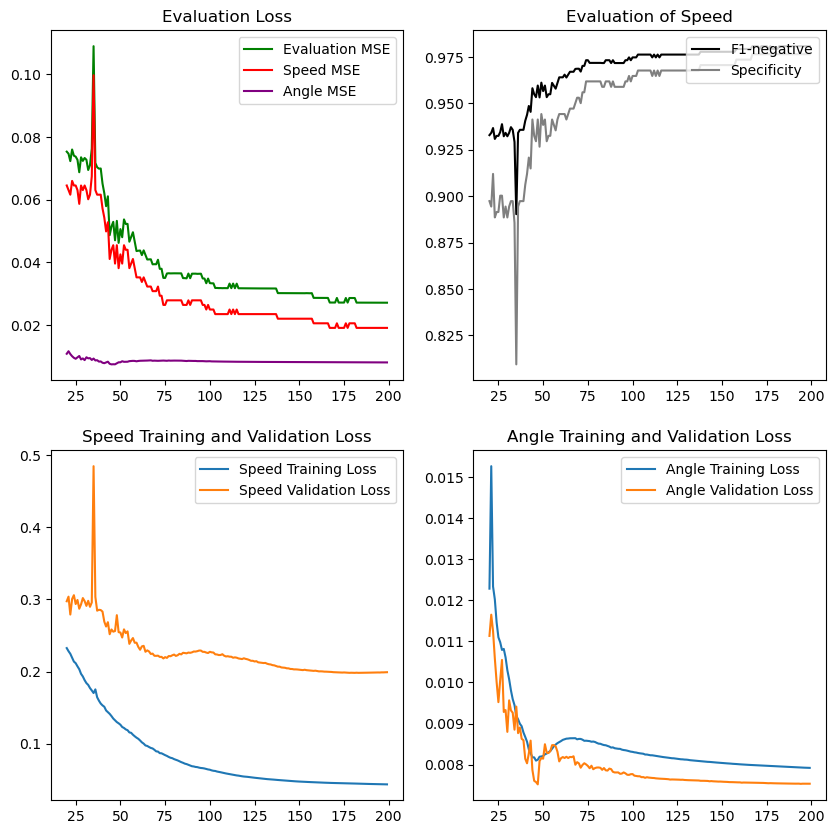

In [16]:
# --- ANALYSE ---
name = evaluate_model(history, evaluation_callback, f_score_beta, epochs, epoch_offset=20)

In [13]:
# --- MAKE SUBMISSION ---
test_model(model, test_image_paths, image_shape, batch_size, speed_threshold, name, directory)

Make submission? (y/n)
>>> y
26/26 [==============================] - 0s 8ms/step


In [14]:
# --- SAVE MODEL ---
save_model(model, name, directory)

Save model? (y/n)
>>> y
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc0cb02340>, 139621013294736), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc0cb141c0>, 139621945827456), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc0cb1cfa0>, 139621945828336), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7efc0cb32e20>, 139621945828736), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shap

INFO:tensorflow:Assets written to: /home/ppyhd1/DeepDreams/models/tf/0.02401/assets


INFO:tensorflow:Assets written to: /home/ppyhd1/DeepDreams/models/tf/0.02401/assets
